# ART Example 1: Maximize Limonene Production

In this notebook we demonstrate the usage of the Automatic Recommendation Tool (ART) to recommend strain designs for improving limonene production. 


Tested using **ART_v3.6** kernel on jprime.lbl.gov. 

## Inputs and Outputs

#### Required files to run this notebook:
- None, data will be automatically drawn from EDD

#### Files generated by running this notebook:

- `ART_training_EDDstyle.csv`, a file for ART front end import 
- Standard ART output files (containing recommendations, predictive accuracy metrics, plots of predictions vs observations for the train data set, pickle file containing previously trained ART object) in the corresponding directory.
- `ARTrecommendations.csv`, a file containing the ART recommendations


#### Required files to run this notebook:
- None, data will be automatically drawn from EDD

#### Files generated by running this notebook:

- `ART_training_EDDstyle.csv`, a file for ART front end import 
- Standard ART output files (containing recommendations, predictive accuracy metrics, plots of predictions vs observations for the train data set, pickle file containing previously trained ART object) in the corresponding directory.
- `ARTrecommendations.csv`, a file containing the ART recommendations


#### Required file to run this notebook:
- `Limonene_data_for_ART.csv` file from the `data` directory

#### Files generated by running this notebook:
 
- a pickle file containing a trained ART object 
- a file containing predictive accuracy metrics
- plot of (cross-validated) predictions vs observations for the train data set
- `draws.txt`, containing all draws from the optimization procedure
- `recommendations.csv`, containing the ART recommendations for the next cycle
- plot of predictive distributions for the recommendations
- plot of success probabilities for the recommendations


## Setup

The first step is to make sure the `ART` library is available in your kernel.

Clone the corresponding git repository:


`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.



We can then add library to the path and do the necessary import:


In [1]:
import sys
sys.path.append('../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
    
from art.core import *                                  


## User parameters

Define some of the ART input parameters:

In [2]:
user_params = {}
user_params['data_file'] = './data/Limonene_data_for_ART.csv'            # Training data file
user_params['input_var'] = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                            'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                            'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU'] # A list of the relevant input variables (features) to use for model building    
user_params['response_var'] = ['4-isopropenyl-1-methyl-cyclohexene']      # Response variable
user_params['objective'] = 'maximize'                                     # Type of the objective
user_params['threshold'] = 0.2                                            # Relative threshold for defining success (e.g. setting to 0.2 means 
# improving the production from the best in the data set by 20% is considered a success)
user_params['num_recommendations'] = 10                                   # Number of recommendations to be provided
user_params['output_directory'] = './results/Limonene'                    # Directory to store output files
user_params['verbose'] = 1                                                # Amount of information to be displayed


## Load the study data into a dataframe

In [3]:
df = utils.load_study(data_file=user_params['data_file'])

In [4]:
df.head()

,Study ID,Study Name,Line Name,Line Description,Strain(s),Media,Starting OD,Protocol Name,Assay ID,Assay Name,Type,Measurement Updated,X Units,Y Units,24
0,54255,Limonene data for ART,B.Mm,DH1 with single plasmid (medium-copy) expressi...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55297,B.Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.31867
1,54255,Limonene data for ART,A.Ml,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55298,A.Ml,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.88600
2,54255,Limonene data for ART,BL.Mm,DH1 with two plasmid (B + high with extra copy...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55299,BL.Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.40000
3,54255,Limonene data for ART,A.Mh,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55300,A.Mh,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.29333
4,54255,Limonene data for ART,A.Hl,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,2.5,OD600,55301,A.Hl,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.03733


## Running ART to create a predictive model of production and generate recommendations

The first step is to create a dictionary that contains the settings for ART:

In [6]:
art_params = {
    'response_var': user_params['response_var'],
    'input_var': user_params['input_var'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],   
    'seed': 10,
    'cross_val': True,
    'verbose': user_params['verbose'],
    'output_directory': user_params['output_directory']
}

In this case we have proteomics data which will be used to determine maximum production of limonene in terms of total protein concentrations. Then target protein concentrations will be reported back to the user.

In this data set the maximum value is 128 (mg/L) of limonene. The objective is to predict strain designs which will maximize production. Successful designs are considered to be those that exceed the maximum observed production by 20%, as specified by the `threshold` variable.


### Training ART

With the configuration stored in `art_params`, we now run ART (this takes ~20min if cross-validation is performed, otherwise it takes ~5min):

Best pipeline: ElasticNetCV(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=DEFAULT), ElasticNetCV__l1_ratio=0.4, ElasticNetCV__tol=DEFAULT)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:26<00:00, 841.25draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: LassoLarsCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=average), LassoLarsCV__normalize=False)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 894.81draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.717556329754526, but should be close to 0.8. Try to increase the number of tuning steps.


Best pipeline: RidgeCV(LassoLarsCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=average), LassoLarsCV__normalize=False))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1093.11draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Best pipeline: KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=1, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=uniform)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 807.32draws/s]


Best pipeline: ElasticNetCV(PolynomialFeatures(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=cosine, FeatureAgglomeration__linkage=complete), PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=DEFAULT, PolynomialFeatures__interaction_only=DEFAULT), ElasticNetCV__l1_ratio=0.15000000000000002, ElasticNetCV__tol=0.0001)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:25<00:00, 857.47draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: LinearSVR(RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15000000000000002, RandomForestRegressor__min_samples_leaf=16, RandomForestRegressor__min_samples_split=15, RandomForestRegressor__n_estimators=100), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.01)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:28<00:00, 778.39draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: RandomForestRegressor(RidgeCV(Normalizer(input_matrix, Normalizer__norm=l1)), RandomForestRegressor__bootstrap=DEFAULT, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=4, RandomForestRegressor__min_samples_split=4, RandomForestRegressor__n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1023.58draws/s]


Best pipeline: RidgeCV(VarianceThreshold(PCA(input_matrix, PCA__iterated_power=10, PCA__svd_solver=randomized), VarianceThreshold__threshold=0.5))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:23<00:00, 940.68draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: ElasticNetCV(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=DEFAULT, PolynomialFeatures__interaction_only=DEFAULT), ElasticNetCV__l1_ratio=0.5, ElasticNetCV__tol=1e-05)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:25<00:00, 876.74draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Best pipeline: ElasticNetCV(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), ElasticNetCV__l1_ratio=0.15000000000000002, ElasticNetCV__tol=0.1)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:22<00:00, 967.87draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,20.792671,110.270971,20.987192,872.797404,0.353393
Random Forest Regressor,22.429269,203.616382,19.106541,868.132024,0.356850
TPOT Regressor,17.832590,112.304969,17.791996,634.556381,0.529893
Support Vector Regressor,27.350860,167.500699,29.190907,1600.178560,-0.185483
Kernel Ridge Regressor,20.304178,115.537782,23.297712,955.043003,0.292462
K-NN Regressor,18.444413,150.032013,17.981583,663.533698,0.508425
Gaussian Process Regressor,27.571575,267.617494,21.815826,1236.122027,0.084226
Gradient Boosting Regressor,17.517936,143.540533,17.502119,613.202227,0.545713
Ensemble Model,17.036013,108.145723,15.293800,524.126081,0.611704


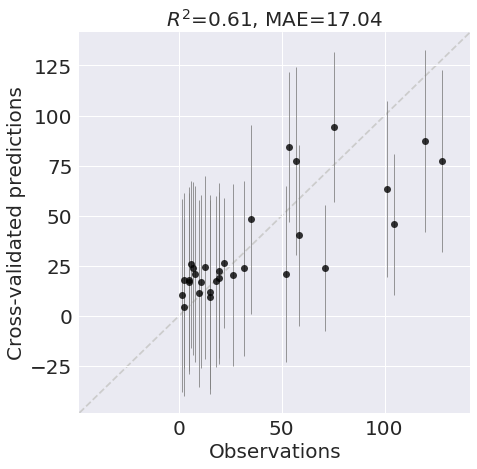

Best pipeline: RidgeCV(DecisionTreeRegressor(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=average), DecisionTreeRegressor__max_depth=4, DecisionTreeRegressor__min_samples_leaf=13, DecisionTreeRegressor__min_samples_split=14))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:19<00:00, 1134.98draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.097560,0.990360,0.222568,5.905438e-02,0.999956
Random Forest Regressor,9.768798,65.567237,8.755191,1.720828e+02,0.872514
TPOT Regressor,15.493968,119.417013,13.047534,4.103012e+02,0.696031
Support Vector Regressor,25.816751,151.889853,28.865585,1.499727e+03,-0.111063
Kernel Ridge Regressor,12.574144,82.423719,11.951892,3.009568e+02,0.777038
K-NN Regressor,14.385255,102.244064,14.015780,4.033776e+02,0.701160
Gaussian Process Regressor,0.000021,0.000213,0.000014,6.456474e-10,1.000000
Gradient Boosting Regressor,0.103705,1.008630,0.083743,1.776753e-02,0.999987
Ensemble Model,10.466518,69.649149,9.940372,2.083590e+02,0.845638


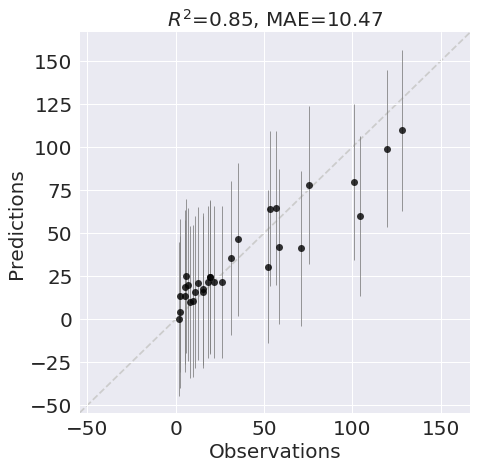

Finished 2.00 percent in 2.368329 s Acceptance rate = 0.316Adding DE jump with weight 20
Finished 99.00 percent in 94.919132 s Acceptance rate = 0.230838
Run Complete


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,4-isopropenyl-1-methyl-cyclohexene
0,0.218342,0.260281,2.491320,1.480789,4.063428,14.112370,4.740141,0.440511,0.542264,123.420252
1,0.234206,0.186433,2.631791,1.466854,4.079612,14.040201,4.735709,0.425831,0.582515,123.257852
2,0.241177,0.593763,2.635061,1.476942,3.974173,14.200707,4.744894,0.449222,0.542008,123.228856
3,0.241057,0.446392,2.430833,1.351156,4.218492,13.962244,4.731818,0.420172,0.547300,123.045569
4,0.311280,0.541223,2.625381,1.403694,4.035341,14.167358,4.705895,0.434928,0.542202,122.710899
5,0.249659,0.143297,2.572427,1.477782,4.085782,13.607532,4.708181,0.418856,0.555863,122.550819
6,0.258514,0.496217,1.868473,1.471325,4.085621,14.142297,4.747490,0.417627,0.578515,122.378148
7,0.281085,0.212649,2.466410,1.348570,4.124726,13.888037,4.737759,0.436761,0.558939,122.357037
8,0.233142,0.330961,2.517194,1.448379,4.214362,13.728017,4.733667,0.442724,0.575529,122.326542
9,0.218596,0.159485,2.460587,1.155999,3.860295,13.853541,4.737678,0.424737,0.542023,122.297105


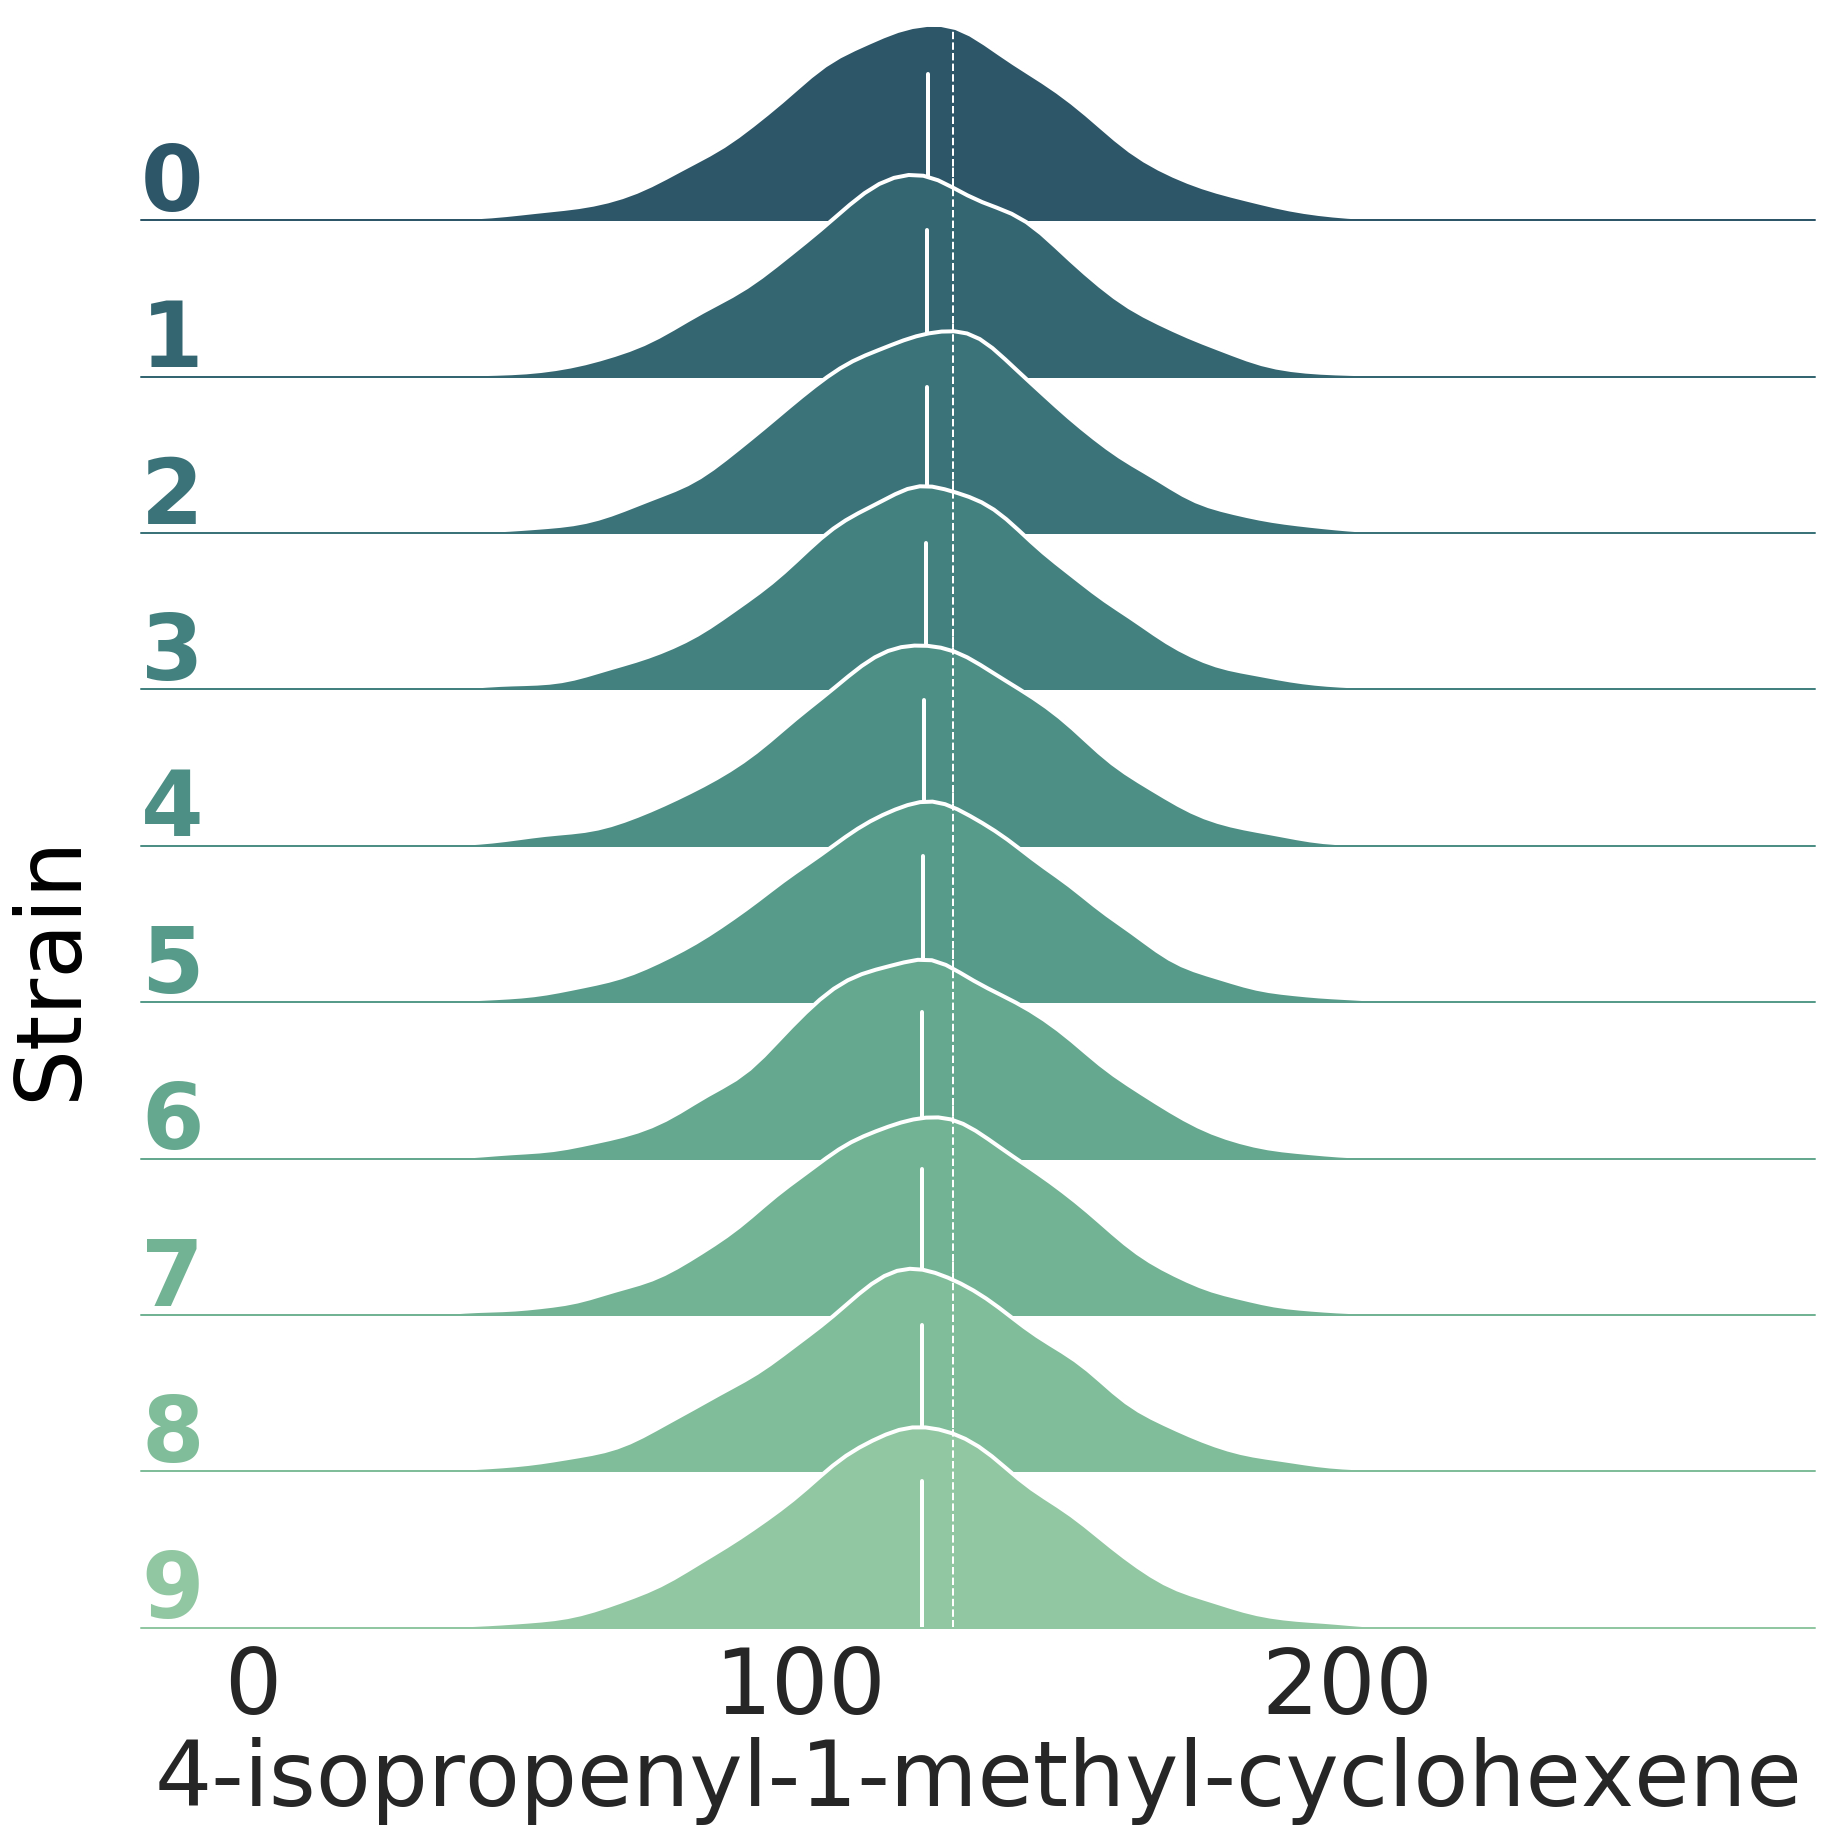

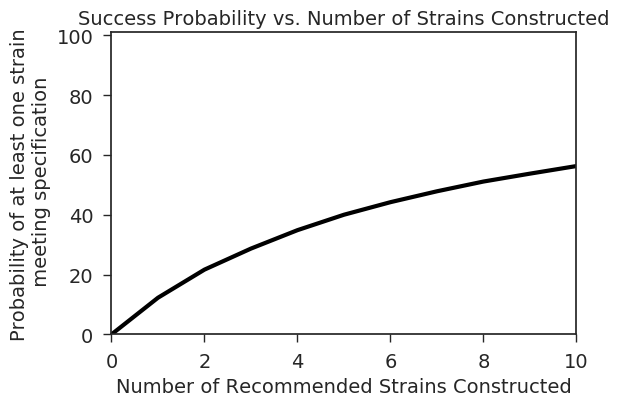

CPU times: user 18min 30s, sys: 5min 9s, total: 23min 39s
Wall time: 20min 19s


In [7]:
%%time
art = RecommendationEngine(df, **art_params)


### Using ART for generating recommendations

Once the model is trained, we use it to find inputs that will optimize production. 

Sample the space of protein expressions in search of those that maximize the limonene production.

Now we use ART to recommend the designs that will optimize production. The objective function is defined as the mean predicted production:  

<!-- <font color='red'> _____**This is not very clear..** </font>  -->

Perform sampling-based optimization and find recommendations with default options (`niter=100000` for number of samples collected, `alpha=None` for a purely exploitative strategy, and `rel_eng_accuracy=20%` for relative engineering accuracy):

In [17]:
draws = art.parallel_tempering_opt()
art.recommend(draws)

Finished 2.00 percent in 3.043618 s Acceptance rate = 0.3525Adding DE jump with weight 20
Finished 99.00 percent in 108.751443 s Acceptance rate = 0.266919
Run Complete


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,4-isopropenyl-1-methyl-cyclohexene
0,0.210467,1.327463,3.158487,0.413204,2.249686,11.643243,4.655928,0.446959,0.543795,82.342633
1,0.168229,0.992986,3.262478,0.401294,2.242982,11.564634,4.648075,0.438649,0.621512,82.046547
2,0.173191,1.280789,3.284687,0.411372,2.073877,11.589146,4.706476,0.421579,0.688475,81.891044
3,0.217886,0.974747,3.228631,0.405483,2.238396,11.684475,4.594105,0.448662,0.552076,81.816430
4,0.205228,1.217749,3.241586,0.414771,2.185778,11.542409,4.712419,0.556559,0.594692,81.675371
5,0.182666,1.284837,3.261029,0.401372,2.251627,11.512361,4.685976,0.520349,0.744602,81.520261
6,0.273203,1.313864,3.295376,0.407302,2.278826,11.311913,4.616265,0.477662,0.545211,81.352723
7,0.234940,1.427510,3.256411,0.386058,2.164260,11.670886,4.722949,0.420077,0.658063,81.268104
8,0.214070,0.724753,3.245143,0.413167,2.250223,11.629898,4.600947,0.449267,0.671452,81.018387
9,0.234203,1.306449,3.264384,0.413494,2.211044,11.410356,4.656731,0.509666,0.719750,81.012919


(Neglected recommendations are those that do not satisfy the engineering accuracy requirement)

The Table above provides a set of predictions which if followed should maximize the chance of successful strain engineering.

We can visualize the predicted distribution for all recommendations:

Heatmap of the mean of the final model as function of the two principal components of input varibles:

In [27]:
utils.save_pkl_object(art)